# Прогнозирование оттока клиентов в телекоммуникационной компании

<b> Цели и задачи проекта<b>

Наша задача состоит в том, чтобы в течении двух недель предоставить оператору связи «Ниединогоразрыва.ком» лучшую модель прогнозирования оттока клиентов с метрикой AUC-ROC ≥ 0.88, опираясь на полученные данные о более семи тысячах пользователей, их демографических характеристиках, услугах, которыми они пользуются, длительности пользования услугами оператора, методе оплаты, размере оплаты. Для бизнеса очень важно иметь представление о том, почему и когда клиенты могут отказаться от услуг. Наличие надежной и точной модели прогнозирования оттока поможет оператору минимизировать уход клиентов за счет предложенных промокодов и определения специальных условий обслуживания

<b>Описание услуг<b>

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b>Описание данных<b>

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

1. Загрузка и ознакомление
2. Предобработка
  - привести данные к нужным типам
  - найти и исправить ошибки в данных, если они есть
3. Разведочный анализ
  - определить кто пользуется услугами
  - какими видами услуг пользуются
  - процент ушедших пользователей
  - графическое отображение
4. Разработка и исследование моделей
  - разделить исходные данные на выборки
  - исследуем качество разных моделей, меняя гиперпараметры
  - проверяем качество модели на тестовой выборке и лучшую модель рекомендуем для прогнозирования оттока клиентов
5. Подготовка отчета

<b>Предварительный анализ исходных данных<b>

In [1]:
!pip install pandas-profiling

     |████████████████████████████████| 268 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 35.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 69.7 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 102.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 5.5 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=694170ccee4123197ae4c5b16545a4dff47cf2c597297d54e78cb96cf20545ef
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [2]:
!pip install category_encoders

     |████████████████████████████████| 72 kB 245 kB/s eta 0:00:01


In [3]:
#импорт библиотек
import pandas as pd
import pandas_profiling
from scipy import stats as st
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
RANDOM_STATE = 12345
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# загрузка данных
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [5]:
# функция, позволяющая сформировать отчет с показателями разведочного анализа данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.profile_report())

In [6]:
df_check(contract)

Общая информация



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Первая часть отчёта содержит раздел Overview (Обзор), дающий основные сведения о данных. Датасет об информации о договоре состоит из 8 столбцов и 7043 строк. Процент и количество пропущенных значений равно 0. Мы видим, что у нас присутствует 3 типа переменных: категориальные, булевы, численные. Визуализированно распределение переменных в виде гистограммы, шкалы распределения по классам. В предупреждениях отсутствует наличие дубликатов. Но есть информация о высокой корреляции BeginDate с EndDate и Type. Название столбца customerID не соответствуют CamelCase, нужно привести к единому стилю. Тип столбцов BeginDate и EndDate должен быть датой, тип столбца TotalCharges должен быть вещественным, как и MonthlyCharges.

In [7]:
df_check(personal)

Общая информация



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет о персональных данных клиентов состоит из 5 столбцов и 7043 строк. Процент и количество пропущенных значений равно 0. Мы видим, что у нас присутствует 2 типа переменных: категориальные, булевы. Визуализированно распределение переменных в виде шкалы распределения по классам. В предупреждениях отсутствует наличие дубликатов. Но есть информация о высокой корреляции Partner с Dependents. Название столбцов customerID, gender не соответствуют CamelCase, нужно привести к единому стилю. 

In [8]:
df_check(internet)

Общая информация



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет об информации интернет-услуг состоит из 8 столбцов и 5517 строк. Процент и количество пропущенных значений равно 0. Мы видим, что у нас присутствует 2 типа переменных: категориальные, булевы. Визуализированно распределение переменных в виде шкалы распределения по классам. В предупреждениях отсутствует наличие дубликатов. Но есть информация о высокой корреляции StreamingTV с StreamingMovies. Название столбца customerID не соответствуют CamelCase, нужно привести к единому стилю. 

In [9]:
df_check(phone)

Общая информация



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет об информации телефонии состоит из 2 столбцов и 6361 строк. Процент и количество пропущенных значений равно 0. Мы видим, что у нас присутствует 2 типа переменных: категориальные, булевы. Визуализированно распределение переменных в виде шкалы распределения по классам. В предупреждениях отсутствует наличие дубликатов. Название столбца customerID не соответствуют CamelCase, нужно привести к единому стилю. 

Так как описание столбцов не было дано в задаче, сделаем это для облегчения понимания:

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный документ об оплате,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка
- customerID - код клиента
- gender - пол клиента 

Услуги internet отмечены Yes или Not а зависимости от наличия подключения к каждой услуге, а в столбце InternetService указан тип подключения.

Всего заключены контракты с 7043 пользователями, из которых только интернетом пользуются 5517 пользователей, только телефоном - 6361 пользователь.

In [10]:
# занесем все датафреймы в словарь
df_list = {'contract': contract, 
           'internet': internet, 
           'personal': personal, 
           'phone': phone}

In [11]:
#приведем все названия к CamelCase
for key in df_list:
    print('Таблица', key)
    
    df_cols = df_list[key].columns.to_list()
    print('До:\t', ', '.join(df_cols))
    
    for i, col in enumerate(df_cols):
        if col[0].islower():
            df_cols[i] = col[0].upper() + col[1:]
            
    df_list[key].columns = df_cols
    print('После:\t', ', '.join(df_list[key].columns))
    print()

Таблица contract
До:	 customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges
После:	 CustomerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges

Таблица internet
До:	 customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
После:	 CustomerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

Таблица personal
До:	 customerID, gender, SeniorCitizen, Partner, Dependents
После:	 CustomerID, Gender, SeniorCitizen, Partner, Dependents

Таблица phone
До:	 customerID, MultipleLines
После:	 CustomerID, MultipleLines



Поменяем типы данных в столбцах. В поле EndDate хранятся не только даты, но ещё и признак 'No', для пользователей, которые не ушли и остаются клиентами компании. Чтобы не возникло ошибки при приведении к типу datetime, заменим 'No' на дату выгрузки данных '2020-02-01'. В исходном наборе данных пользователи, завершившие контракт в этот день, отсутствуют, поэтому легко сможем вернуть признак 'No' в случае необходимости.

In [12]:
contract[contract['EndDate'] == '2020-02-01']

Empty DataFrame
Columns: [CustomerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []

In [13]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [14]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'].replace('No', '2020-02-01'))

In [15]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [16]:
contract.head()

CustomerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  
0           Electronic check           29.85         29.85  
1               Mailed check           56.95       1889.50  
2               Mailed check           53.85        108.15  
3  Bank transfer (automatic)           42.30       1840.75  
4           Electronic check           70.70        151.65

<b>Вывод<b>

В этом разделе познакомились с данными, привели их к нужным типам там, где необходимо. Привели названия столбцов в CamelCase.

<b>Исследовательский анализ данных<b>

Подготовим данные для обучения моделей, объединив их в одну таблицу.

В таблице с контрактами и персональными данными все пользователи уникальны (видим в отчетах профалинг). Выберем таблицу с конктрактами и присоединим к ней остальные таблицы по CustomerID:

In [17]:
df = contract.merge(personal, on='CustomerID', how='left')
df = df.merge(internet, on='CustomerID', how='left')
df = df.merge(phone, on='CustomerID', how='left')

In [18]:
df.head()

CustomerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  Gender  \
0           Electronic check           29.85         29.85  Female   
1               Mailed check           56.95       1889.50    Male   
2               Mailed check           53.85        108.15    Male   
3  Bank transfer (automatic)           42.30       1840.75    Male   
4           Electronic check           70.70        151.65  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL             No   
1              0      No         No             DSL            Yes   
2              0      No         No             DSL            Yes   
3              0      No         No             DSL            Yes   
4              0      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

В объединённой таблице появятся пропуски для строк с клиентами, у которых подключен только интернет, либо только телефон.

In [20]:
#приведем все булевы признаки к числовым значениям: 0 - No, 1 - Yes.
def yes_no_to_bool(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return x

for col in df.columns:
    unique_vals = df[col].unique()
    if 'Yes' in unique_vals:
        df[col] = df[col].apply(yes_no_to_bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   float64       
 14  OnlineBackup      5517 n

/tmp/ipykernel_31/1672418833.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Yes' in unique_vals:


In [21]:
df['IsInContract'] = 1
df.loc[df['EndDate'] == '2020-02-01', 'IsInContract'] = 0
df.head()

CustomerID  BeginDate    EndDate            Type  PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month                 1   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                 0   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                 0   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

               PaymentMethod  MonthlyCharges  TotalCharges  Gender  \
0           Electronic check           29.85         29.85  Female   
1               Mailed check           56.95       1889.50    Male   
2               Mailed check           53.85        108.15    Male   
3  Bank transfer (automatic)           42.30       1840.75    Male   
4           Electronic check           70.70        151.65  Female   

   SeniorCitizen  ...  Dependents  InternetService OnlineSecurity  \
0              0  ...           0              DSL            0.0   
1              0  ...           0              DSL            1.0   
2              0  ...           0              DSL            1.0   
3              0  ...           0              DSL            1.0   
4              0  ...           0      Fiber optic            0.0   

   OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0           1.0               0.0          0.0          0.0              0.0   
1           0.0               1.0          0.0          0.0              0.0   
2           1.0               0.0          0.0          0.0              0.0   
3           0.0               1.0          1.0          0.0              0.0   
4           0.0               0.0          0.0          0.0              0.0   

   MultipleLines  IsInContract  
0            NaN             0  
1            0.0             0  
2            0.0             1  
3            NaN             0  
4            0.0             1  

[5 rows x 21 columns]

Введем новый признак, который будет показывать кол-во дней, проведенное клиентом в компании:

In [22]:
df['ClientActiveDays'] = (df['EndDate'] - df['BeginDate']).dt.days

In [23]:
df.head()

CustomerID  BeginDate    EndDate            Type  PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month                 1   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                 0   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                 0   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

               PaymentMethod  MonthlyCharges  TotalCharges  Gender  \
0           Electronic check           29.85         29.85  Female   
1               Mailed check           56.95       1889.50    Male   
2               Mailed check           53.85        108.15    Male   
3  Bank transfer (automatic)           42.30       1840.75    Male   
4           Electronic check           70.70        151.65  Female   

   SeniorCitizen  ...  InternetService  OnlineSecurity OnlineBackup  \
0              0  ...              DSL             0.0          1.0   
1              0  ...              DSL             1.0          0.0   
2              0  ...              DSL             1.0          1.0   
3              0  ...              DSL             1.0          0.0   
4              0  ...      Fiber optic             0.0          0.0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  MultipleLines  \
0               0.0          0.0          0.0              0.0            NaN   
1               1.0          0.0          0.0              0.0            0.0   
2               0.0          0.0          0.0              0.0            0.0   
3               1.0          1.0          0.0              0.0            NaN   
4               0.0          0.0          0.0              0.0            0.0   

   IsInContract  ClientActiveDays  
0             0                31  
1             0              1036  
2             1                61  
3             0              1371  
4             1                61  

[5 rows x 22 columns]

Есть пропуски в признаках: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, возникшие после объединения данных. Пропуск в таблице TotalCharges, возникший после изменения типа данных.

Поработаем с пропусками. Заполним пропуски нулями, так как у нас нет сведений о наличии той или иной функции у определённого клиента. 

In [24]:
list_ = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines','TotalCharges', 'InternetService', 'StreamingTV', 'StreamingMovies']
for col in list_:
    df[col] = df[col].fillna(0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   float64       
 14  OnlineBackup      7043 n

Посмотрим лучше на условия, которые предложены клинтам и что является тригером для ухода

Подготовим функции для построения графиков

In [26]:
def oneplot(df=df, title1='', xl='', yl='', height=3, width=15):
    
    fig, ax = plt.subplots()
    
    plt.rcParams['font.size'] = '14'
    
    ax.minorticks_on()
    
    line = sns.lineplot(data=df, palette='mako',linewidth=3, dashes=False)
    
    line.set_title(title1, fontdict={'fontsize': 16})
    line.set_ylabel(yl, fontdict={'fontsize': 12})
    line.set_xlabel(xl, fontdict={'fontsize': 12})
    
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    ax.grid(which='minor',color = 'lightblue', linewidth = 1, linestyle=':')
    
    fig.set_figheight(height)
    fig.set_figwidth(width)
    
    return line

In [27]:
def barplot_sns(df, X, Y, title1='', xlabel1='', ylabel1='', rotation_x=0, figsize_1=(15, 5), h=None):    
    
    fig, ax = plt.subplots(figsize=figsize_1)
    
    bar = sns.barplot(data=df, x=X, y=Y, palette='mako', hue=h)
    
    bar.set_title(title1, fontdict={'fontsize': 14})
    
    bar.set_xlabel(xlabel1, fontsize=14)
    bar.set_ylabel(ylabel1, fontsize=14)
    
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    plt.xticks(rotation=rotation_x)
    
    return bar

In [28]:
def kdeplot(df, xlabel1='',
                 figsize_1=(15, 5), label1='', suptitle1='', ylabel1='', lg='', hue1=None):
    
    fig, ax = plt.subplots(figsize=figsize_1)

    fig.suptitle(suptitle1, fontsize=16)

    kdeplot_t = sns.kdeplot(df, color='mediumblue', 
                            alpha=.4, shade=True, label=label1, hue=hue1) 

    kdeplot_t.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    kdeplot_t.set_xlabel(xlabel1, fontsize=14)
    kdeplot_t.set_ylabel(ylabel1, fontsize=14)
        
    return kdeplot_t

Рассмотрим через какое количество дней, в среднем, клиенты уходят

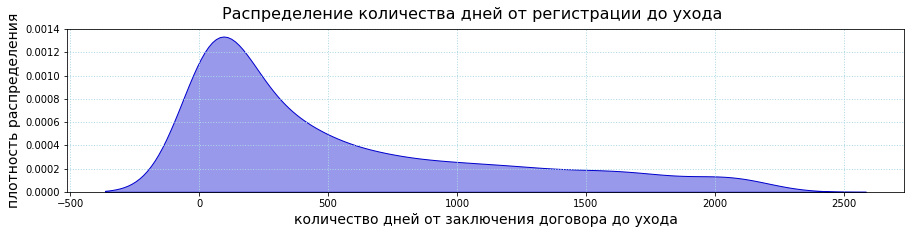

In [29]:
kdeplot(df.loc[df['IsInContract'] > 0]['ClientActiveDays'], 
        xlabel1='количество дней от заключения договора до ухода', 
        figsize_1=(15, 3), 
        suptitle1='Распределение количества дней от регистрации до ухода', 
        ylabel1='плотность распределения', 
        lg='количество дней')
plt.show()

In [30]:
df.loc[df['IsInContract'] > 0]['ClientActiveDays'].describe().T

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: ClientActiveDays, dtype: float64

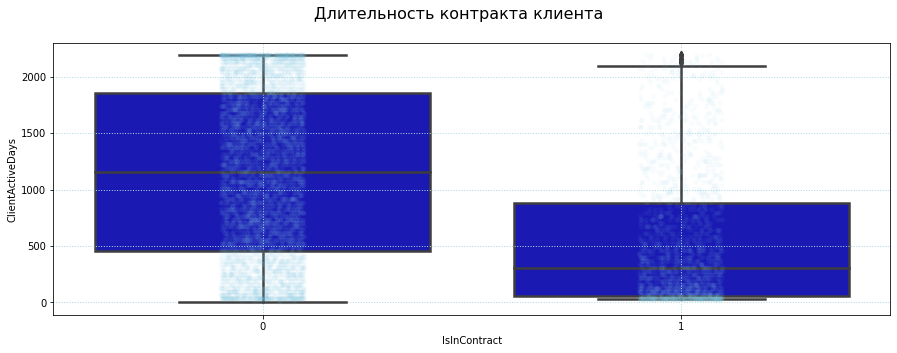

In [31]:
fig, axs = plt.subplots(figsize=(15, 5))
    
fig.suptitle('Длительность контракта клиента', fontsize=16)
       
sns.boxplot(x='IsInContract', y='ClientActiveDays', data=df, color='mediumblue', linewidth=2.5)
sns.stripplot(x='IsInContract', y='ClientActiveDays', data=df, marker="o", alpha=0.05, color="skyblue")
        
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

Медианная длительность контракта у ушедших клиентов значительно ниже - около 300 дней, тогда как для оставшихся - около 1200.  
Длительность контракта от 0 до > 2000 дней для всех групп, при этом расмах значений для ушедших клиентов в основном от 0 до 2000 дней.

В целом, чем дольше клиент пользуется услугами, тем с меньшей вероятностью уходит. До 50% пользователей уходят до года пользования услугами - около 304 дней.   
В среднем - пользователи уходят спустя около 550, при этом высокое стандартное отклонение и разница между медианой и средним говорят о выбросах в данных, поэтому ориентироваться будем на медиану в 304 дня.  

Рассмотрим распределение стоимости услуг для ушедших и оставшихся клиентов.

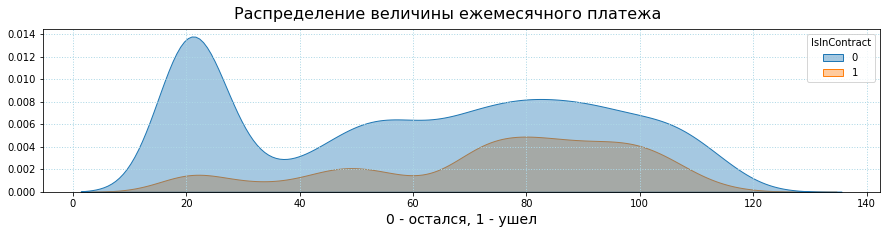

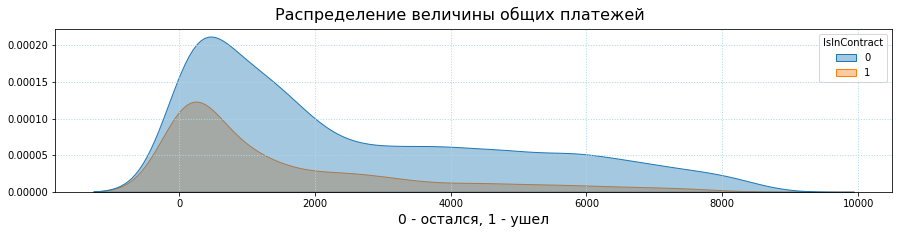

In [32]:
kdeplot(df['MonthlyCharges'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение величины ежемесячного платежа', 
        ylabel1='', hue1=df['IsInContract'])
kdeplot(df['TotalCharges'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение величины общих платежей', 
        ylabel1='', hue1=df['IsInContract'])

plt.show()

Пик распределения величины ежемесячного платежа для ушедших клиетов выше, чем для оставшихся. Ушедшие клиенты платили больше.

In [33]:
df[['IsInContract', 'MonthlyCharges', 'TotalCharges', 'ClientActiveDays']].groupby(by='IsInContract').median()

MonthlyCharges  TotalCharges  ClientActiveDays
IsInContract                                                
0                     64.425      1679.525              1157
1                     79.650       703.550               304

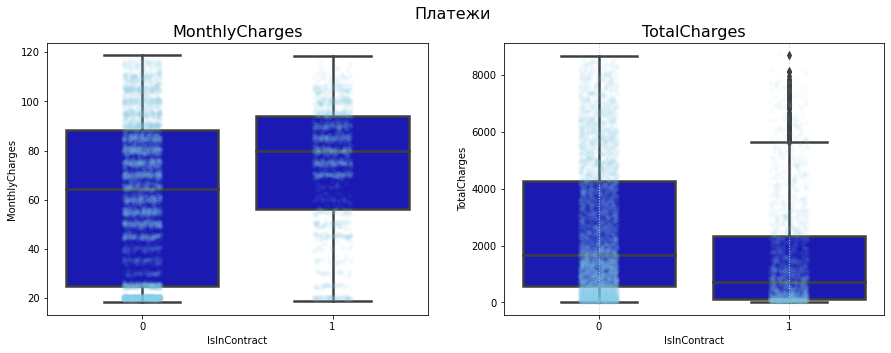

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
fig.suptitle('Платежи', fontsize=16)
       
sns.boxplot(x='IsInContract', y='MonthlyCharges', data=df, color='mediumblue', linewidth=2.5, ax=axs[0])
sns.stripplot(x='IsInContract', y='MonthlyCharges', data=df, marker="o", alpha=0.05, color="skyblue", ax=axs[0])
        
axs[0].set_title('MonthlyCharges', fontsize=16)
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

sns.boxplot(x='IsInContract', y='TotalCharges', data=df, color='mediumblue', linewidth=2.5, ax=axs[1])
sns.stripplot(x='IsInContract', y='TotalCharges', data=df, marker="o", alpha=0.05, color="skyblue", ax=axs[1])

axs[1].set_title('TotalCharges', fontsize=16)
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

Есть выбросы в общих платежах для ушедших клиентов.  Они попадают в номарльные значения для оставшихся клиентов.  
Разброс нормальных значений общих платежей для оставшихся клиентов от 0 до > 8000, для ушедших от 0 до 6000.

Медианный ежемесячный платеж у ушедих клиентов выше, в целом разброс значений ежемесячного платежа для обеих групп одинаковый.

Медианный ежемесячный платеж у ушедших клиентов выше на примерно 20%.

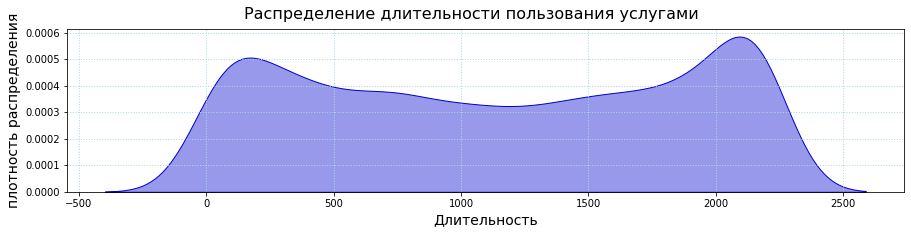

In [35]:
kdeplot(df.loc[df['IsInContract']==0]['ClientActiveDays'], 
            xlabel1='Длительность', 
            figsize_1=(15, 3), 
            suptitle1='Распределение длительности пользования услугами', 
            ylabel1='плотность распределения', 
            lg='количество дней')
plt.show()

На графике наблюдаются два пика - около 200 и около 2200. В целом, количество дней пользования услуг от 0 до 2500.

Посмотрим на пользователей заключивших и расторгнувших договор

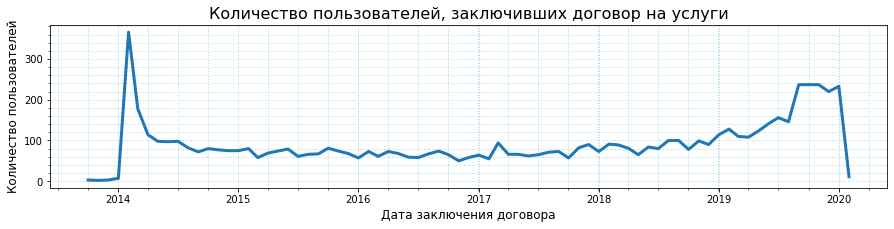

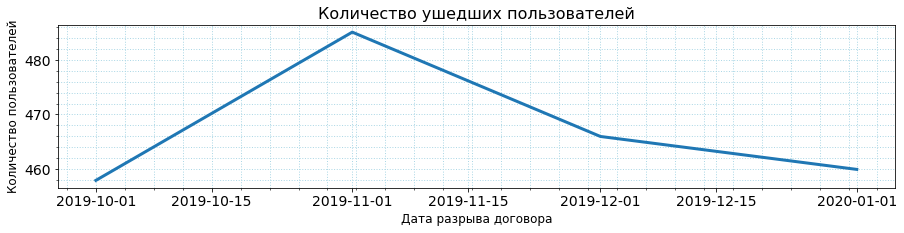

In [36]:
oneplot(df=(df['BeginDate'].value_counts().sort_index(ascending=True)),
        title1='Количество пользователей, заключивших договор на услуги', 
        xl='Дата заключения договора', 
        yl='Количество пользователей')

oneplot(df=((df.loc[df['EndDate'] < '2020-02-01']['EndDate']).value_counts().sort_index(ascending=True)),
        title1='Количество ушедших пользователей', 
        xl='Дата разрыва договора', 
        yl='Количество пользователей')
plt.show()

Наибольшее количество клиентов заключили договор в 2014 году, более 300. В следующие года количество новых пользователей было примерно одинковым, и с 2019 года начало увеличиваться. С середины 2019 года произошел скачок, количество новых пользователей увеличилось до 200.  

Уходить пользоавтели стали с конца 2019 года, или их уход не фиксировался. 

Проверим тип оплаты для оставшихся и ушедших клиентов

In [38]:
def share(column_, df=df):
    
    tabl = df[['IsInContract',
                     'CustomerID',
                     column_]].groupby(by=['IsInContract', 
                                           column_]).count().sort_values(by=['IsInContract', 
                                                                             'CustomerID'], 
                                                                         ascending=False).reset_index()
    
    tabl['share_all'] = tabl['CustomerID'] / (tabl['CustomerID'].sum())
    
    tabl['share_leave'] = 0
    
    tabl.loc[tabl['IsInContract']==0, 'share_leave'] = tabl['CustomerID'] / (df['IsInContract'].value_counts()[0])
    
    tabl.loc[tabl['IsInContract']==1, 'share_leave'] = tabl['CustomerID'] / (df['IsInContract'].value_counts()[1])
    
    tabl[['share_leave', 'share_all']] = np.round((tabl[['share_leave', 'share_all']]), 2)
    
    return tabl

In [39]:
Type_= share(column_='Type')
Type_

IsInContract            Type  CustomerID  share_all  share_leave
0             1  Month-to-month        1655       0.23         0.89
1             1        One year         166       0.02         0.09
2             1        Two year          48       0.01         0.03
3             0  Month-to-month        2220       0.32         0.43
4             0        Two year        1647       0.23         0.32
5             0        One year        1307       0.19         0.25

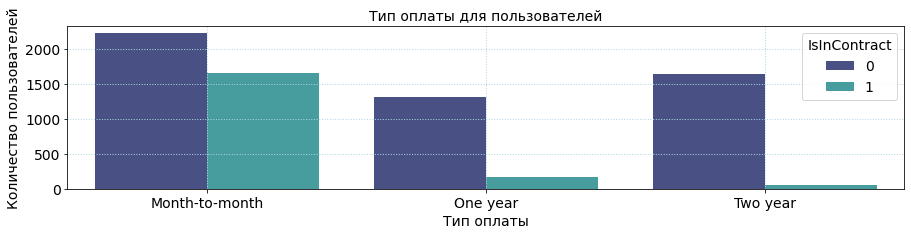

In [40]:
barplot_sns(Type_, X=Type_['Type'], Y=Type_['CustomerID'], 
            title1='Тип оплаты для пользователей', xlabel1='Тип оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=Type_['IsInContract'])
plt.show()

- 55% всех пользователей используют оплату month-to-month.   
- тип оплаты month-to-month используют в основном все ушедшие клиенты - их доля от общеего числа пользоватлеей составляет 23% и 88% от всех ушедших.   
- среди ушедших клиентов только 12% использовали тип оплаты one year или two year.

In [41]:
payment_method = share(column_='PaymentMethod')
payment_method

IsInContract              PaymentMethod  CustomerID  share_all  share_leave
0             1           Electronic check        1071       0.15         0.57
1             1               Mailed check         308       0.04         0.16
2             1  Bank transfer (automatic)         258       0.04         0.14
3             1    Credit card (automatic)         232       0.03         0.12
4             0               Mailed check        1304       0.19         0.25
5             0           Electronic check        1294       0.18         0.25
6             0    Credit card (automatic)        1290       0.18         0.25
7             0  Bank transfer (automatic)        1286       0.18         0.25

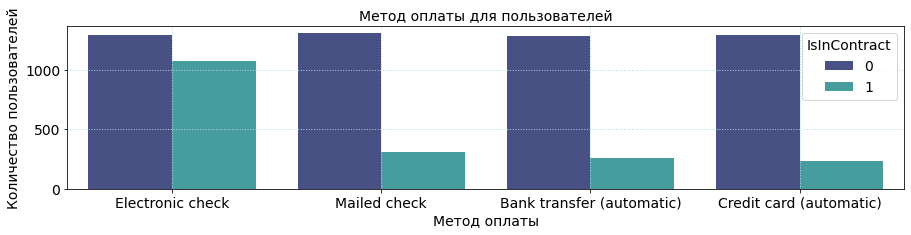

In [42]:
barplot_sns(payment_method, X=payment_method['PaymentMethod'], Y=payment_method['CustomerID'], 
            title1='Метод оплаты для пользователей', xlabel1='Метод оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=payment_method['IsInContract'])
plt.show()

Оставшиеся пользователи в равной степени используют все 4 метода оплаты, тогда как среди ушедших пользователей в основном использовался electronic check.

In [43]:
int_type = share(column_='InternetService')
int_type

IsInContract InternetService  CustomerID  share_all  share_leave
0             1     Fiber optic        1297       0.18         0.69
1             1             DSL         459       0.07         0.25
2             1               0         113       0.02         0.06
3             0             DSL        1962       0.28         0.38
4             0     Fiber optic        1799       0.26         0.35
5             0               0        1413       0.20         0.27

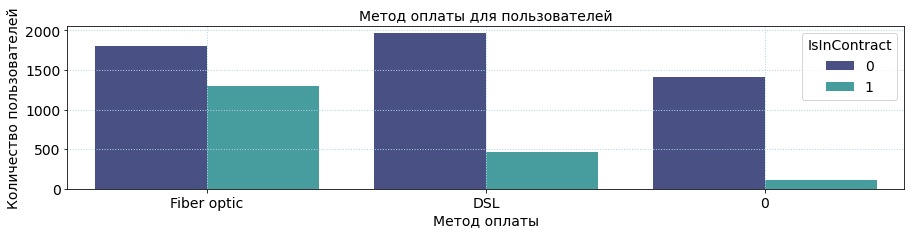

In [44]:
barplot_sns(int_type, X=int_type['InternetService'], Y=int_type['CustomerID'], 
            title1='Метод оплаты для пользователей', xlabel1='Метод оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=int_type['IsInContract'])
plt.show()

Основная часть ушедших пользователей использовала интренет по оптоволокну - fiber optic - 70% от ушедших и 18% от всех пользователей. 
Ушедших пользоватлей, которые не использовали интернет 2% от всех, а тех, кто использовал технологию DSL 7%.   
Всего DSL исопльзовали 35% пользователей.

In [45]:
int_type = share(column_='OnlineSecurity')
int_type

IsInContract  OnlineSecurity  CustomerID  share_all  share_leave
0             1             0.0        1574       0.22         0.84
1             1             1.0         295       0.04         0.16
2             0             0.0        3450       0.49         0.67
3             0             1.0        1724       0.24         0.33

In [46]:
for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
          'TechSupport','StreamingTV', 'StreamingMovies']:
    display(share(column_=i))

IsInContract  OnlineSecurity  CustomerID  share_all  share_leave
0             1             0.0        1574       0.22         0.84
1             1             1.0         295       0.04         0.16
2             0             0.0        3450       0.49         0.67
3             0             1.0        1724       0.24         0.33

IsInContract  OnlineBackup  CustomerID  share_all  share_leave
0             1           0.0        1346       0.19         0.72
1             1           1.0         523       0.07         0.28
2             0           0.0        3268       0.46         0.63
3             0           1.0        1906       0.27         0.37

IsInContract  DeviceProtection  CustomerID  share_all  share_leave
0             1               0.0        1324       0.19         0.71
1             1               1.0         545       0.08         0.29
2             0               0.0        3297       0.47         0.64
3             0               1.0        1877       0.27         0.36

IsInContract  TechSupport  CustomerID  share_all  share_leave
0             1          0.0        1559       0.22         0.83
1             1          1.0         310       0.04         0.17
2             0          0.0        3440       0.49         0.66
3             0          1.0        1734       0.25         0.34

IsInContract  StreamingTV  CustomerID  share_all  share_leave
0             1          0.0        1055       0.15         0.56
1             1          1.0         814       0.12         0.44
2             0          0.0        3281       0.47         0.63
3             0          1.0        1893       0.27         0.37

IsInContract  StreamingMovies  CustomerID  share_all  share_leave
0             1              0.0        1051       0.15         0.56
1             1              1.0         818       0.12         0.44
2             0              0.0        3260       0.46         0.63
3             0              1.0        1914       0.27         0.37

70-80 % ушедшиих клиентов не пользовались дополнительными услугами, за исключением StreamingTV, StreamingMovies. Около 60% ушедших пользоватлеей использовали эти услуги. 

Рассмотрим связана ли как-то персонализированная информация о поле, партренере человека с тем, что клиент ушел.

In [47]:
for i in ['Gender', 'SeniorCitizen','Partner','Dependents']:
    display(share(column_=i))

IsInContract  Gender  CustomerID  share_all  share_leave
0             1  Female         939       0.13         0.50
1             1    Male         930       0.13         0.50
2             0    Male        2625       0.37         0.51
3             0  Female        2549       0.36         0.49

IsInContract  SeniorCitizen  CustomerID  share_all  share_leave
0             1              0        1393       0.20         0.75
1             1              1         476       0.07         0.25
2             0              0        4508       0.64         0.87
3             0              1         666       0.09         0.13

IsInContract  Partner  CustomerID  share_all  share_leave
0             1        0        1200       0.17         0.64
1             1        1         669       0.09         0.36
2             0        1        2733       0.39         0.53
3             0        0        2441       0.35         0.47

IsInContract  Dependents  CustomerID  share_all  share_leave
0             1           0        1543       0.22         0.83
1             1           1         326       0.05         0.17
2             0           0        3390       0.48         0.66
3             0           1        1784       0.25         0.34

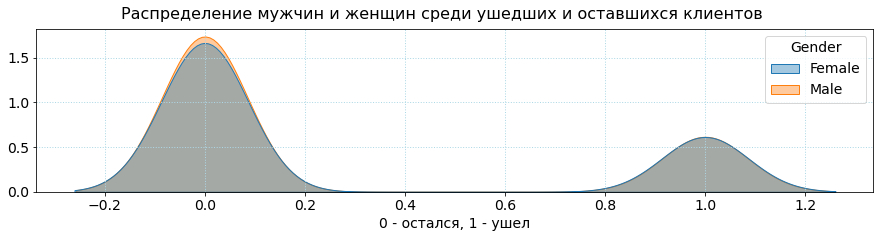

In [48]:
kdeplot(df['IsInContract'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение мужчин и женщин среди ушедших и оставшихся клиентов', 
        ylabel1='', hue1=df['Gender'])
plt.show()

Распределение одинаковое и для женщин и для мужчин. Пол не влияет на факт ухода клиента

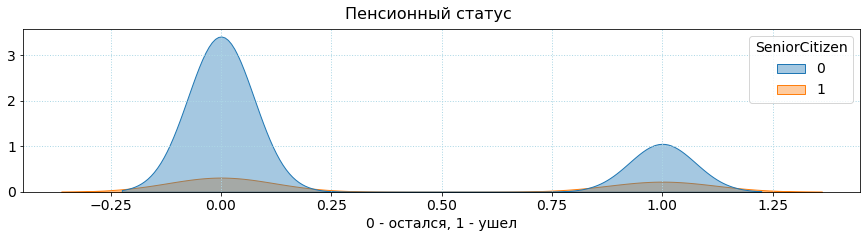

In [49]:
kdeplot(df['IsInContract'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Пенсионный статус', 
        ylabel1='', hue1=df['SeniorCitizen'])
plt.show()

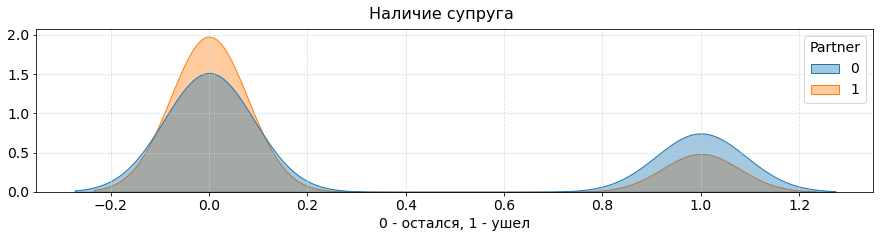

In [50]:
kdeplot(df['IsInContract'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Наличие супруга', 
        ylabel1='', hue1=df['Partner'])
plt.show()

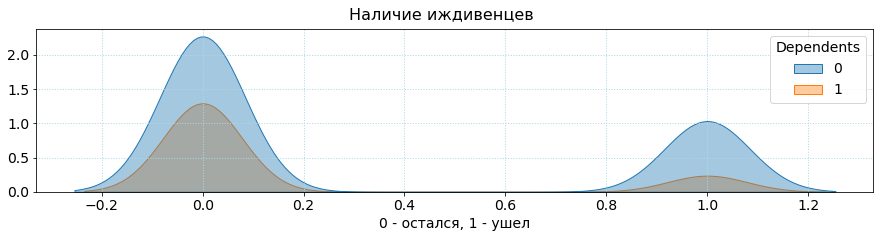

In [51]:
kdeplot(df['IsInContract'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Наличие иждивенцев', 
        ylabel1='', hue1=df['Dependents'])
plt.show()

В целом, ушедших клиентов без супруга больше, чем с супругом. У 64% ушедших пользователей спруга нет.    
В остальном, уход клиента с персональными данными не связан.

In [52]:
tel = share(column_='MultipleLines')
tel

IsInContract  MultipleLines  CustomerID  share_all  share_leave
0             1            0.0        1019       0.14         0.55
1             1            1.0         850       0.12         0.45
2             0            0.0        3053       0.43         0.59
3             0            1.0        2121       0.30         0.41

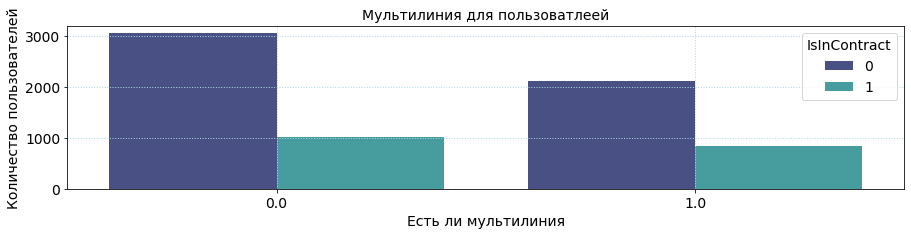

In [53]:
barplot_sns(tel, X=tel['MultipleLines'], Y=tel['CustomerID'], 
            title1='Мультилиния для пользоватлеей', xlabel1='Есть ли мультилиния', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=tel['IsInContract'])
plt.show()

В основном, ушедшие пользователи поделились на два типа - 45% пользовались 1 линией телефона, другие 45% более 1 линией.   
Пользователей без телефонной линией по 10% в каждой группе.

In [54]:
#посмотрим на отчет по нашему получившемуся датасету, который содержит информацию по корреляции
display(df.profile_report())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В полученном отчете по анализу данных видно, что:

Есть сильные корреляции признаков (в отчете вкладка Correlations). При подготовке данных к обучению удалим: TotalCharges, BeginDate, EndDate, InternetService, StreamingTV, StreamingMovies, так как признаки сильно скоррелированы с MonthlyCharges.

TotalCharges также сильно коррелирует с ClientActiveDays, MonthlyCharges. Признак TotalCharges будет удален из датасета для обучения моделей.

Также удалим признак CustomerID, так как все идентификаторы уникальны и это поле не несёт логической ценности.

В целевом признаке присутствует дисбаланс классов: 73% клиентов остаются в компании и только 27% уходят.

Признаки, которые выделены как сильно скоррелированные, будут удалены перед обучением модели.

In [55]:
cols_to_drop = ['CustomerID', 'TotalCharges', 'InternetService', 'StreamingTV', 'StreamingMovies', 'BeginDate', 'EndDate']

In [56]:
df = df.drop(columns=cols_to_drop)

<b>Вывод<b>

В этом разделе данные из разных файлов были объединены в одну таблицу, заполнены пропуски, обнаруженные после объединения и преобразования типов данных, также обнаружен дисбаланс классов и найдены корреляции между признаками. Неинформативные признаки были удалены.

<b>Подготовка данных к обучению<b>

Разобьём данные на обучающую и тестовую выборки в соотношении 3:1.

In [57]:
features = df.drop(columns=['IsInContract'],axis=1)
target = df['IsInContract']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=target)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5282, 14), (1761, 14), (5282,), (1761,))

In [58]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2329 to 1127
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   int64  
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   Gender            5282 non-null   object 
 5   SeniorCitizen     5282 non-null   int64  
 6   Partner           5282 non-null   int64  
 7   Dependents        5282 non-null   int64  
 8   OnlineSecurity    5282 non-null   float64
 9   OnlineBackup      5282 non-null   float64
 10  DeviceProtection  5282 non-null   float64
 11  TechSupport       5282 non-null   float64
 12  MultipleLines     5282 non-null   float64
 13  ClientActiveDays  5282 non-null   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 619.0+ KB


In [59]:
#закодируем категориальные данные
encoder = (ce.OneHotEncoder(cols= features_train.select_dtypes('object').columns,drop_invariant=True))
features_train = encoder.fit_transform(features_train)
features_test = encoder.transform(features_test)

<b>Вывод<b>

Данные подготовлены для использования в обучении моделей.

<b>Обучение моделей<b>

Исследование оттока клиентов - это задача бинарной классификации. В качестве основной метрики, подходящей под эту задачу берем ROC-AUC. В проекте будут исследованы модели:

<li>дерево решений,
<li>случайный лес,
<li>CatBoostClassifier,
<li>LGBMClassifier

В качестве борьбы с дисбалансом применим взвешивание классов. Алгоритм посчитает, во сколько раз класс "0" встречается чаще класса "1" и объектам редкого класса присвоит больший вес.

In [60]:
#CatBoostRegressor
model_cat = CatBoostClassifier(random_state=RANDOM_STATE)
parametrs = { 'verbose': [10, 100, 200],
              'learning_rate': [0.01, 0.1],
              'early_stopping_rounds': [200,300]}
scorer = make_scorer(roc_auc_score, greater_is_better = True)
grid = GridSearchCV(model_cat, parametrs, cv=5, scoring = scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

0:	learn: 0.6854968	total: 48.1ms	remaining: 48s
10:	learn: 0.6242590	total: 63.7ms	remaining: 5.73s
20:	learn: 0.5769839	total: 78.1ms	remaining: 3.64s
30:	learn: 0.5393989	total: 94.2ms	remaining: 2.94s
40:	learn: 0.5108161	total: 110ms	remaining: 2.58s
50:	learn: 0.4882976	total: 127ms	remaining: 2.35s
60:	learn: 0.4703641	total: 144ms	remaining: 2.21s
70:	learn: 0.4547383	total: 163ms	remaining: 2.14s
80:	learn: 0.4432568	total: 181ms	remaining: 2.05s
90:	learn: 0.4332335	total: 198ms	remaining: 1.98s
100:	learn: 0.4246381	total: 214ms	remaining: 1.9s
110:	learn: 0.4174072	total: 232ms	remaining: 1.86s
120:	learn: 0.4112214	total: 249ms	remaining: 1.81s
130:	learn: 0.4058870	total: 267ms	remaining: 1.77s
140:	learn: 0.4009267	total: 285ms	remaining: 1.73s
150:	learn: 0.3966803	total: 301ms	remaining: 1.69s
160:	learn: 0.3926468	total: 318ms	remaining: 1.66s
170:	learn: 0.3890710	total: 335ms	remaining: 1.62s
180:	learn: 0.3860036	total: 351ms	remaining: 1.59s
190:	learn: 0.3832208	

In [61]:
#обучим модель градиентного бустинга
model_lgbm = LGBMClassifier(random_state =RANDOM_STATE, class_weight = 'balanced')
parametrs = {'n_estimators': [50, 100, 500], 'max_depth': [10, 20, 30]}
scorer = make_scorer(roc_auc_score, greater_is_better = True)
grid = GridSearchCV(model_lgbm, parametrs, cv=5, scoring = scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'max_depth': 20, 'n_estimators': 100}
LGBMClassifier(class_weight='balanced', max_depth=20, random_state=12345)
0.7986566622466574


In [62]:
#обучим модель дерева решений
model_dtc = DecisionTreeClassifier(random_state =RANDOM_STATE, class_weight = 'balanced')
parametrs = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
scorer = make_scorer(roc_auc_score, greater_is_better = True)
grid = GridSearchCV(model_dtc, parametrs, cv=5, scoring = scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, min_samples_leaf=2, random_state=12345)
0.7545517141075162


In [63]:
#обучим модель случайного леса
model_fсс= RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
parametrs = { 'n_estimators': range (10, 20, 11),
              'max_depth': range (1,11),
              'min_samples_leaf': range (1,5)}
scorer = make_scorer(roc_auc_score, greater_is_better = True)
grid = GridSearchCV(model_fсс, parametrs, cv=5, scoring = scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 10}
RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=4,
                       n_estimators=10, random_state=12345)
0.7667533503844359


| Модель  | Метрика ROC-AUC | Parameters | 
| -------|:----:|:------:|
|RandomForestClassifier|0.767   |max_depth=6, n_estimators=10| 
|DecisionTreeClassifier|0.755  |max_depth=4|  
|**CatBoostClassifier**|**0.803** |verbose=10|
|LGBMClassifier|0.799    |max_depth=20, n_estimators=100|

<b>Проверка качества модели<b>

In [64]:
#перезапишем лучшие параметры в модель CatBoostClassifier
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, verbose=10, learning_rate=0.1, early_stopping_rounds=200)
model_cat.fit(features_train, target_train)

0:	learn: 0.6252578	total: 2.67ms	remaining: 2.66s
10:	learn: 0.4206946	total: 22.6ms	remaining: 2.03s
20:	learn: 0.3842604	total: 43.5ms	remaining: 2.03s
30:	learn: 0.3696605	total: 63.2ms	remaining: 1.98s
40:	learn: 0.3592703	total: 81.9ms	remaining: 1.91s
50:	learn: 0.3514425	total: 99.6ms	remaining: 1.85s
60:	learn: 0.3419618	total: 118ms	remaining: 1.81s
70:	learn: 0.3328678	total: 136ms	remaining: 1.77s
80:	learn: 0.3230663	total: 153ms	remaining: 1.74s
90:	learn: 0.3116277	total: 172ms	remaining: 1.72s
100:	learn: 0.3022789	total: 189ms	remaining: 1.69s
110:	learn: 0.2953566	total: 207ms	remaining: 1.66s
120:	learn: 0.2865831	total: 225ms	remaining: 1.64s
130:	learn: 0.2781458	total: 243ms	remaining: 1.61s
140:	learn: 0.2708327	total: 261ms	remaining: 1.59s
150:	learn: 0.2662251	total: 279ms	remaining: 1.57s
160:	learn: 0.2593410	total: 297ms	remaining: 1.55s
170:	learn: 0.2529062	total: 316ms	remaining: 1.53s
180:	learn: 0.2485221	total: 338ms	remaining: 1.53s
190:	learn: 0.243

In [65]:
#проверим модель на тестовой выборке
probabilities_valid = model_cat.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC на тестовой выборке равен', roc_auc_score(target_test,probabilities_one_valid))
print('Accuracy на тестовой выборке равена', accuracy_score(target_test,  model_cat.predict(features_test)))
print('F1-метрика на тестовой выборке равена', f1_score(target_test,  model_cat.predict(features_test)))

AUC-ROC на тестовой выборке равен 0.9218870491049117
Accuracy на тестовой выборке равена 0.8745031232254401
F1-метрика на тестовой выборке равена 0.7396937573616019


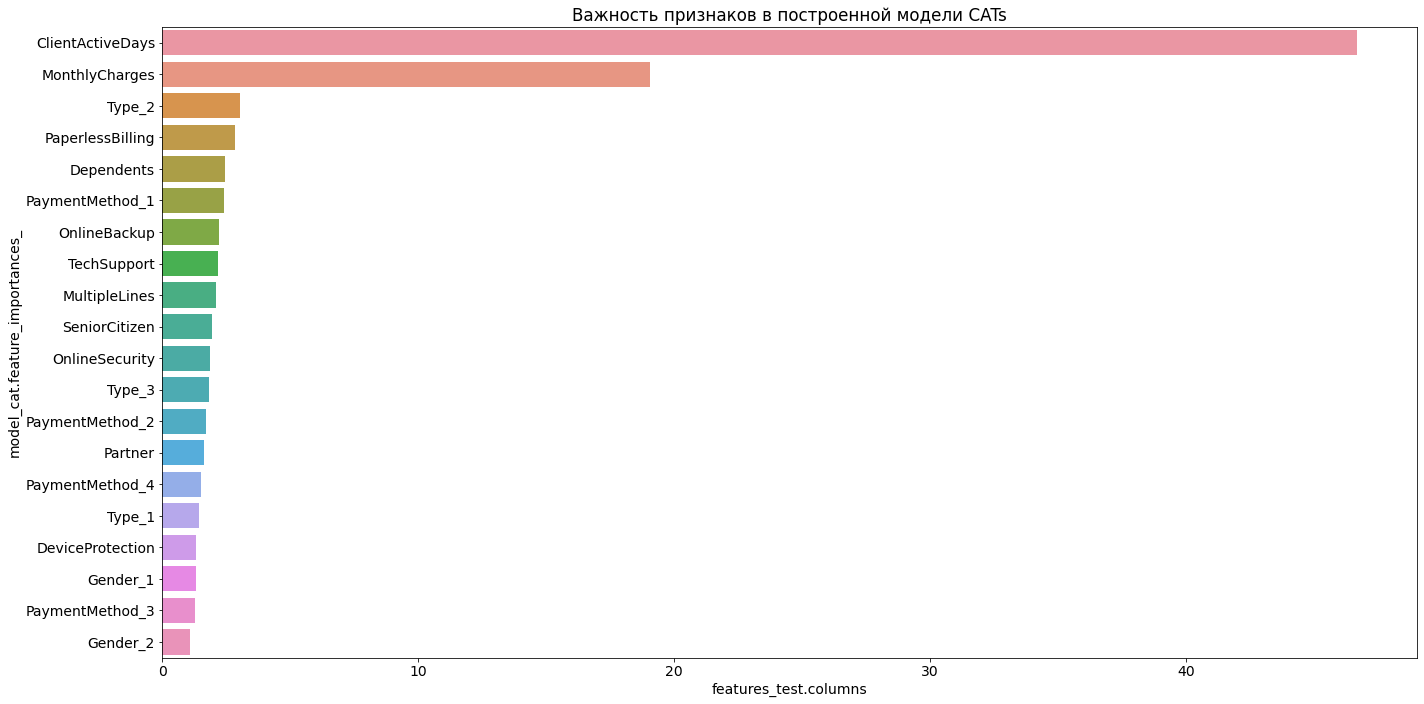

In [67]:
#проверим важность признаков для данной модели
feature_importances=pd.DataFrame(sorted(zip(model_cat.feature_importances_,features_test.columns)), columns=['features_test.columns','model_cat.feature_importances_'])
plt.figure(figsize=(20, 10))
sns.barplot(x="features_test.columns", y="model_cat.feature_importances_", data=feature_importances.sort_values(by="features_test.columns", ascending=False).iloc[:50])
plt.title('Важность признаков в построенной модели CATs')
plt.tight_layout()
plt.show()

Для прогнозирования оттока клиентов были обучены несколько моделей, решающих задачу бинарной классификации. Подобраны оптимальные параметры, чтобы метрика качества ROC-AUC была наибольшей.

На тестовой выборке получены следующие результаты:

| Метрика  | Значение |
| -------|:----:|
|AUC-ROC|0.922  |
|Accuracy|0.875  | 
|F1-метрика|0.740 | 

Требуемую в проекте точность AUC-ROC ≥ 0.88 удалось получить с одной итерационной моделью: CatBoostClassifier.

Самые важные признаки по версии модели CatBoostClassifier - это кол-во дней, которое клиент пользуется услугами компании (ClientActiveDays) и ежемесячные траты клиента на услуги (MonthlyCharges).

<b>Отчет<b>

Нам была поставлена задача: спрогнозировать бинарный признак, уйдет клиент от оператора связи или нет. В случае, если вероятность того, что клиент может уйти, будет высокой, ему предложат специальные условия по использованию услуг компании. Мы были ограничены метрикой AUC-ROC ≥ 0.88 прогнозируемой лучшей модели и сроком выполнения работы- две недели.

Для решения задачи предоставлены данные, состоящие из 4-х из файлов:

<li>contract.csv — информация о договоре;
<li>personal.csv — персональные данные клиента;
<li>internet.csv — информация об интернет-услугах;
<li>phone.csv — информация об услугах телефонии.

В ходе работы над задачей были выполнены следующие этапы:

#### Загружены и предобработаны данные:

<li>Для анализа датасетов использована библиотека pandas-profiling
<li>Названия столбцов приведены к единому стилю CamelCase для упрощения дальнейшей работы.
<li>Тип данных в столбцах BeginDate и EndDate заменен на datetime, тип столбца TotalCharges - на float.

#### Проведен исследовательский анализ данных:

<li>Данные объединены в таблицу по уникальности значений CustomerID.
<li>Целевой признак переведен в формат: 0 - клиент ушёл, 1- клиент не ушёл.
<li>Введен новый признак, который показывает кол-во дней, проведенное клиентом в компании
<li>В результате анализа данных также реализованы следующие шаги:
    
     - В объединенной таблице проведена работа с пропусками для строк с клиентами, у которых подключен только интернет, либо только телефон.
     - Пропуски, возникшие после объединения таблиц, заполнены нулями, так как у нас нет сведений о наличии того или иного признака у определенного клиента.
     - Все булевы признаки приведены к числовым значениям: 0 - No, 1 - Yes.
    
<li>Сформирован портрет клиента:
    
     - Значение количества дней,через которое клиенты уходят:в среднем - пользователи уходят спустя 550 дней
     - Распределение стоимости услуг: выяснили,что ушедшие клиенты платили больше
     - Распределение длительности пользования услугами: количество дней пользования услуг от 0 до 2500
     - Год заключения договора: наибольшее количество клиентов заключили договор в 2014 году. В следующие года количество новых пользователей было примерно одинковым, и с 2019 года начало увеличиваться. С середины 2019 года произошел скачок на увеличение. Уходить пользоавтели стали с конца 2019 года.
     - Тип оплаты: клиенты в одинаково большей степени используют month-to-month
     - Метод оплаты: оставшиеся пользователи в равной степени используют все 4 метода оплаты, тогда как среди ушедших пользователей в основном использовался electronic check
     - Интернет и дополнительные услуги: основная часть ушедших пользователей использовала интренет по оптоволокну. Ушедших пользоватлей, которые не использовали интернет 2% от всех, а тех, кто использовал технологию DSL 7%.Всего DSL исопльзовали 35% пользователей. 70-80 % ушедшиих клиентов не пользовались дополнительными услугами, за исключением StreamingTV, StreamingMovies. Около 60% ушедших пользоватлеей использовали эти услуги.
     - Телефонная линия: в основном, ушедшие пользователи поделились на два типа - 45% пользовались 1 линией телефона, другие 45% более 1 линией.Пользователей без телефонной линией по 10% в каждой группе.
     - Персонализированная информация: в целом, персональные данные не влияют на уход клиента. 
    
<li>Для анализа распределений и корреляций признаков иcпользована библиотека pandas-profiling
    
    
[Мультиколлинеарность](https://github.com/karishaqqq/final/blob/main/Phik.jpg)
  

<li>С помощью визуализации выявлено следующее:
    
     - Есть сильные корреляции признаков. При подготовке данных к обучению удалим: TotalCharges, BeginDate, EndDate, InternetService, StreamingTV, StreamingMovies, так как признаки сильно скоррелированы с MonthlyCharges.
     - В целевом признаке присутствует дисбаланс классов: 73% клиентов остаются в компании и только 27% уходят.

#### Данные подготовлены к передаче в модель обучения

<li>Данные разбиты на обучающую и тестовую выборки в соотношении 3:1.
<li>Категориальные переменные закодированы с помощью технологии OneHotEncoder.

#### Обучение и оценка качества моделей

Исследование оттока клиентов - это задача бинарной классификации. В качестве основной метрики, подходящей под эту задачу берем ROC-AUC.

В проекте исследованы модели:

<li>DecisionTreeClassifier,
<li>RandomForestClassifier,
<li>CatBoostClassifier,
<li>LGBMClassifier.
    
В качестве борьбы с дисбалансом использовано взвешивание классов. Алгоритм посчитает, во сколько раз класс "0" встречается чаще класса "1" и объектам редкого класса присвоит больший вес.

При обучении моделей были подобраны оптимальные параметры (Parameters), чтобы метрика качества ROC-AUC была наибольшей.
    
| Модель  | Метрика ROC-AUC | Parameters | 
| -------|:----:|:------:|
|RandomForestClassifier|0.767   |max_depth=6, n_estimators=10| 
|DecisionTreeClassifier|0.755  |max_depth=4|  
|**CatBoostClassifier**|**0.803** |verbose=10|
|LGBMClassifier|0.799    |max_depth=20, n_estimators=100|

Затем качество наилучшей модели проверено на тестовой выборке и получены следующие результаты:

| Метрика  | Значение |
| -------|:----:|
|AUC-ROC|0.922  |
|Accuracy|0.875  | 
|F1-метрика|0.740 |   
    
Требуемую в проекте точность AUC-ROC ≥ 0.88 удалось получить с одной итерационной моделью: CatBoostClassifier.

Также модель была исследована на важность признаков датасета (feature_importances_). Самые важные признаки по версии модели CatBoostClassifier - это кол-во дней, которое клиент пользуется услугами компании (ClientActiveDays) и ежемесячные траты клиента на услуги (MonthlyCharges).
    
[Важность признаков](https://github.com/karishaqqq/final/blob/main/main.jpg)

#### Заключение

Для прогнозирования оттока клиетов лучше всего себя показала итерационная модель CatBoostClassifier, она может быть использована в продакшене.

Мне удалось выполнить все пункты плана. Порядок выполнения был соблюден.

Удалось поработать с выбросами и посчитать другие метрики качества, например, F1 и Accuracy для тестовой выборки. Как оказалось, для выполнения задачи выполненных мной шагов было достаточно.

Трудности обычно возникают в исследовательском анализе данных, если признаков много. Частично эту проблему решает библиотека pandas-profiling, которая строит отчет с анализом данных. Но отчет тоже довольно объемный, необходимо извлечь все особенности датасета.

Также есть трудности с выбором кодировки иподбором гиперпараметров для обучения моделей, подбираю их, опираясь на выбранные модели для обучения и опыт предыдущих проектов.